Script to read in the SBML v2 models and save as comets 

In [2]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import copy
import numpy as np
import pandas as pd
import cometspy as c
import os

os.environ['COMETS_HOME'] = '/projectnb2/talbot-lab-data/zrwerbin/interactions/comets_2.10.5_linux'
os.environ['JAVA_HOME'] = '/share/pkg.7/java/12.0.1/install'
os.environ['PATH'] = '/projectnb2/talbot-lab-data/zrwerbin/venvs/comets/bin:/share/pkg.7/gurobi/9.1.1/install/bin:/share/pkg.7/python3/3.8.10/install/bin:/share/pkg.7/java/12.0.1/install/bin:/projectnb/talbot-lab-data/zrwerbin/temporal_forecast/data_construction/microbe/16S_copy_num_normalize/copy_num_normalize:/usr/java/default/jre/bin:/usr/java/default/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/opt/dell/srvadmin/bin:/bin:/projectnb2/talbot-lab-data/zrwerbin/interactions/comets_2.10.5_linux'
model_dir = "/projectnb2/talbot-lab-data/metabolic_models/curated_models/" # model location

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
NEU = cobra.io.read_sbml_model("/projectnb2/talbot-lab-data/metabolic_models/curated_models/N_cycle/metanet_cobra_sbml/NSP1.COBRA-sbml3.xml")

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


In [5]:
# N cycler models from Octavio-Perez 2015
NEU = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NEU1.COBRA-sbml3.xml')
NET = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NET1.COBRA-sbml3.xml')
NMU = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NMU1.COBRA-sbml3.xml')
NOC = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NOC1.COBRA-sbml3.xml')
NDE = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NDE1.COBRA-sbml3.xml')
NWI = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NWI1.COBRA-sbml3.xml')
NHA = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NHA1.COBRA-sbml3.xml')
NSP = cobra.io.read_sbml_model(model_dir + '/N_cycle/metanet_cobra_sbml/NSP1.COBRA-sbml3.xml')

## Indimesh reduced models, converted to SBML
#iPB = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/zrwerbin/interactions/models/sbml/iPB890_rGEM_v3.xml')
#iJO = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/zrwerbin/interactions/models/sbml/iJO1366_rGEM_v3.xml')
#iRR = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/zrwerbin/interactions/models/sbml/iRR1083_rGEM_v3.xml')
#iJN = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/zrwerbin/interactions/models/sbml/iJN746_rGEM_v3.xml')

Adding exchange reaction EX_MNXM107@BOUNDARY with default bounds for boundary metabolite: MNXM107@BOUNDARY.
Adding exchange reaction EX_MNXM1@BOUNDARY with default bounds for boundary metabolite: MNXM1@BOUNDARY.
Adding exchange reaction EX_MNXM107@BOUNDARY with default bounds for boundary metabolite: MNXM107@BOUNDARY.
Adding exchange reaction EX_MNXM1@BOUNDARY with default bounds for boundary metabolite: MNXM1@BOUNDARY.
Adding exchange reaction EX_MNXM107@BOUNDARY with default bounds for boundary metabolite: MNXM107@BOUNDARY.
Adding exchange reaction EX_MNXM1@BOUNDARY with default bounds for boundary metabolite: MNXM1@BOUNDARY.
Adding exchange reaction EX_MNXM107@BOUNDARY with default bounds for boundary metabolite: MNXM107@BOUNDARY.
Adding exchange reaction EX_MNXM1@BOUNDARY with default bounds for boundary metabolite: MNXM1@BOUNDARY.


In [6]:
iJN_full = cobra.io.read_sbml_model('/projectnb2/talbot-lab-data/zrwerbin/interactions/models/iJN746_bigg.xml')
iJN_full.reactions.get_by_id('BIOMASS_KT_TEMP').lower_bound = 0
iJN_full.reactions.get_by_id('BIOMASS_KT_TEMP').upper_bound = 1000
iJN_comets = c.model(iJN_full)
iJN_comets.ensure_sinks_are_not_exchanges()
iJN_comets.open_exchanges()

OSError: [Errno The file with 'filename' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation: 
%s] /projectnb2/talbot-lab-data/zrwerbin/interactions/models/iJN746_bigg.xml

Got biomass reaction IDs by checking optimized functions (in "convert Indimesh matlab models.ipynb")

In [7]:
iPB.reactions.get_by_id('IR10372').lower_bound = 0
iPB.reactions.get_by_id('IR10372').upper_bound = 1000
iJO.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M').lower_bound  = 0
iJO.reactions.get_by_id('Ec_biomass_iJO1366_WT_53p95M').upper_bound  = 1000
iRR.reactions.get_by_id('biomass_iRR1083_metals').lower_bound = 0
iRR.reactions.get_by_id('biomass_iRR1083_metals').upper_bound = 1000

Fix metabolite names so that they can be exchanged with other species

In [12]:
for metabolite in iJO.metabolites:
    metabolite.id = metabolite.id.replace('[', '_').replace(']', '')
iJO.repair()

for metabolite in iPB.metabolites:
    metabolite.id = metabolite.id.replace('[', '_').replace(']', '')
iPB.repair()

for metabolite in iRR.metabolites:
    metabolite.id = metabolite.id.replace('[', '_').replace(']', '')
iRR.repair()

In [13]:
iPB_c = c.model(iPB)
iPB_c.ensure_sinks_are_not_exchanges()
iPB_c.open_exchanges()

iJO_c = c.model(iJO)
iJO_c.ensure_sinks_are_not_exchanges()
iJO_c.open_exchanges()

iRR_c = c.model(iRR)
iRR_c.ensure_sinks_are_not_exchanges()
iRR_c.open_exchanges()

NEU_c = c.model(NEU)
NEU_c.ensure_sinks_are_not_exchanges()
NEU_c.open_exchanges()

NET_c = c.model(NET)
NET_c.ensure_sinks_are_not_exchanges()
NET_c.open_exchanges()

NMU_c = c.model(NMU)
NMU_c.ensure_sinks_are_not_exchanges()
NMU_c.open_exchanges()

NOC_c = c.model(NOC)
NOC_c.ensure_sinks_are_not_exchanges()
NOC_c.open_exchanges()

NDE_c = c.model(NDE)
NDE_c.ensure_sinks_are_not_exchanges()
NDE_c.open_exchanges()

NWI_c = c.model(NWI)
NWI_c.ensure_sinks_are_not_exchanges()
NWI_c.open_exchanges()

NHA_c = c.model(NHA)
NHA_c.ensure_sinks_are_not_exchanges()
NHA_c.open_exchanges()

NSP_c = c.model(NSP)
NSP_c.ensure_sinks_are_not_exchanges()
NSP_c.open_exchanges()

iJN_c = c.model(iJN)
iJN_c.ensure_sinks_are_not_exchanges()
iJN_c.open_exchanges()

In [14]:
iPB_c.id = "P_stutzeri"
iJO_c.id = "E_coli"
iRR_c.id = "S_enterica"
iJN_c.id = "P_putida"
NEU_c.id = "N_europaea_AOB"
NET_c.id = "N_eutropha_AOB"
NMU_c.id = "N_multiformis_AOB"
NOC_c.id = "N_oceani_AOB"
NDE_c.id = "N_defluvii_NOB"
NWI_c.id = "N_winogradskyi_NOB"
NHA_c.id = "N_hamburgensis_NOB"
NSP_c.id = "N_gracilis_NOB"

This would be the ideal point to save the comets models, but I get errors when I read them back in later. So not now.


Quick check to see if/how the models grow on their own:

In [15]:
solution = NET.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NEU.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NMU.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NOC.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NDE.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NWI.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NHA.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = NSP.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = iPB.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = iJO.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = iRR.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = iJN.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

solution = iJN_full.optimize()
print('Growth Rate: '+str(solution.objective_value)+' 1/h')

Growth Rate: 0.0 1/h
Growth Rate: 16.777810339157842 1/h
Growth Rate: 0.0 1/h
Growth Rate: 19.292260036060636 1/h
Growth Rate: 4.6031190734841925 1/h
Growth Rate: 4.603119073484193 1/h
Growth Rate: 4.6031190734841925 1/h
Growth Rate: 4.6031190734841925 1/h
Growth Rate: 1.5171672392194477 1/h
Growth Rate: 2.702439356885505 1/h
Growth Rate: 2.31690041252798 1/h
Growth Rate: 2.0 1/h


NameError: name 'iJN_full' is not defined

In [21]:
NEU.objective = "NEU"

ValueError: invalid objective

In [20]:
NEU.medium

{'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_no2_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_n2o_e': 1000.0,
 'EX_no_e': 1000.0,
 'EX_nh2oh_e': 1000.0,
 'EX_biomass_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_co2_e': 1000.0}

Our simulated world will be a 100x100 box lattice. The left-hand side, where x = 0, will be the root. The top, where y = 0, will be the air. Therefore, the biomass and the rocks will be distributed everywhere else. To ensure that we don't attempt to place biomass where rocks are placed, we first determine the rock locations. Specifically, we will create 70 rocks which are impervious to any biomass or metabolite. These rocks will have an average size of 15 boxes. To pick these locations, we use the helper function grow_rocks, in the utils subpackage:

In [8]:
from cometspy.utils import grow_rocks, pick_random_locations

grid_width =  10 # narrow, so we can really look at stratification
grid_height =  60
n_rocks = 30 # 70
rock_locs = grow_rocks(n = n_rocks, xrange = [1,grid_width-1],yrange = [1,grid_height-1],mean_size = 2)

Each species will have biomass seeded at 60 different locations, with no overlap. We will use the helper function pick_random_locations for this, which is useful as it can take in a previously-generated list of tuples of x-y locations as “forbidden” locations, such as the rock locations.

First we make a copy of the rock_locs so we don't accidentally alter it, and call this copy forbidden_locs.


Next we pick the random locations for each species, adding these locations to the forbidden locs as we go so as to prevent overlap.


In [9]:
import copy
forbidden_locs = copy.deepcopy(rock_locs)

founders_per_species = 30 # 60
n_species = 12
init_locs = pick_random_locations(n = founders_per_species*n_species, 
                                   xrange = [1,grid_width], yrange = [1,grid_height], 
                                   forbidden_locs = forbidden_locs)

spec1_locs = init_locs[1:founders_per_species]
spec2_locs = init_locs[founders_per_species+1:founders_per_species*2]
spec3_locs = init_locs[founders_per_species*2+1:founders_per_species*3]
spec4_locs = init_locs[founders_per_species*3+1:founders_per_species*4]
spec5_locs = init_locs[founders_per_species*4+1:founders_per_species*5]
spec6_locs = init_locs[founders_per_species*5+1:founders_per_species*6]
spec7_locs = init_locs[founders_per_species*6+1:founders_per_species*7]
spec8_locs = init_locs[founders_per_species*7+1:founders_per_species*8]
spec9_locs = init_locs[founders_per_species*8+1:founders_per_species*9]
spec10_locs = init_locs[founders_per_species*9+1:founders_per_species*10]
spec11_locs = init_locs[founders_per_species*10+1:founders_per_species*11]
spec12_locs = init_locs[founders_per_species*11+1:founders_per_species*12]

# Check that there is no overlap (kind of random)
set(spec1_locs) & set(spec2_locs)
set(spec2_locs) & set(spec3_locs)
set(spec1_locs) & set(spec3_locs)
set(spec4_locs) & set(spec2_locs)
set(spec4_locs) & set(spec3_locs)
set(spec5_locs) & set(spec3_locs)
set(spec5_locs) & set(spec2_locs)
set(spec6_locs) & set(spec3_locs)
set(spec6_locs) & set(spec3_locs)
set(spec7_locs) & set(spec3_locs)
set(spec7_locs) & set(spec3_locs)
set(spec8_locs) & set(spec3_locs)
set(spec8_locs) & set(spec3_locs)
set(spec10_locs) & set(spec3_locs)
set(spec11_locs) & set(spec3_locs)
#spec3_locs

#iMM_locs = pick_random_locations(founders_per_species, [1,grid_width],[1,grid_height], forbidden_locs)
#forbidden_locs.extend(iMM_locs)

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

set()

In [10]:
# We set the initial population for each species by using a python list comprehension.

NEU_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec1_locs]
NET_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec2_locs]
NMU_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec3_locs]
NOC_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec4_locs]
NDE_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec5_locs]
NWI_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec6_locs]
NHA_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec7_locs]
NSP_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec8_locs]
iPB_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec9_locs]
iJO_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec10_locs]
iRR_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec11_locs]
iJN_c.initial_pop = [[loc[0],loc[1],1e-8] for loc in spec12_locs]

If we wish to take a look at what locations were chosen, we can easily make an image with matplotlib:

Text(0.5, 1.0, 'species 1-3')

Text(0.5, 1.0, 'species 4-6')

Text(0.5, 1.0, 'species 7-9')

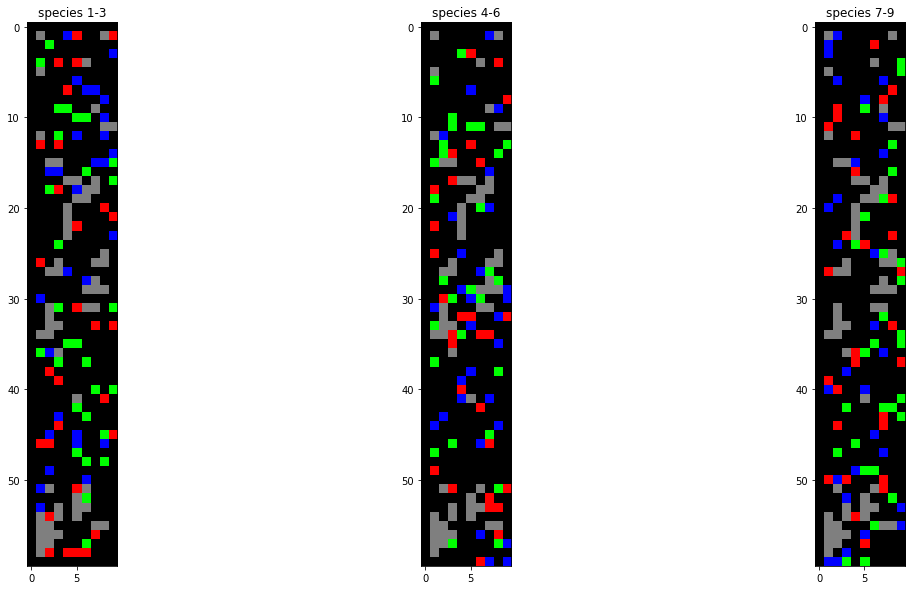

In [110]:
from matplotlib import pyplot as plt
initial_image = np.zeros((grid_height,grid_width,3))
for rock in rock_locs:
    initial_image[rock[1], rock[0]] = .5
for loc in spec1_locs:
    initial_image[loc[1],loc[0],0] = 1
for loc in spec2_locs:
    initial_image[loc[1],loc[0],1] = 1
for loc in spec3_locs:
    initial_image[loc[1],loc[0],2] = 1

initial_image2 = np.zeros((grid_height,grid_width,3))
for rock in rock_locs:
    initial_image2[rock[1],rock[0],0:3] = 0.5 
for loc in spec4_locs:
    initial_image2[loc[1],loc[0],0] = 1
for loc in spec5_locs:
    initial_image2[loc[1],loc[0],1] = 1
for loc in spec6_locs:
    initial_image2[loc[1],loc[0],2] = 1
    
initial_image3 = np.zeros((grid_height,grid_width,3))
for rock in rock_locs:
    initial_image3[rock[1],rock[0],0:3] = 0.5 
for loc in spec7_locs:
    initial_image3[loc[1],loc[0],0] = 1
for loc in spec8_locs:
    initial_image3[loc[1],loc[0],1] = 1
for loc in spec9_locs:
    initial_image3[loc[1],loc[0],2] = 1

initial_figure, initial_axis = plt.subplots(1, 3)
initial_axis[0].imshow(initial_image)
initial_axis[0].set_title("species 1-3")
initial_axis[1].imshow(initial_image2)
initial_axis[1].set_title("species 4-6")
initial_axis[2].imshow(initial_image3)
initial_axis[2].set_title("species 7-9")
initial_figure.set_figheight(10)
initial_figure.set_figwidth(20)
plt.show(initial_figure)

Add models to the layout.

In [123]:
layout = c.layout()
#layout.grid = [grid_height,grid_width]
layout.grid = [grid_width,grid_height]
layout.add_barriers(rock_locs)
layout.add_model(NEU_c)
layout.add_model(NET_c)
layout.add_model(NMU_c)
layout.add_model(NOC_c)
layout.add_model(NDE_c)
layout.add_model(NWI_c)
layout.add_model(NHA_c)
layout.add_model(NSP_c)
layout.add_model(iPB_c)
layout.add_model(iJO_c)
layout.add_model(iRR_c)
layout.add_model(iJN_c)

building empty layout model
models will need to be added with layout.add_model()


We want some metabolites available initially. These include all the typical trace nutrients needed, so we start with the helper function.

After that, however, we want oxygen to mostly diffuse from the air, so we set that value lower. We also add a few other trace metabolites homogeneously throughout the environment that were not added with the helper function.

To make the air layer, we set static media, which keep that metabolite at a fixed value.  We also set a static level of zero oxygen at the "bottom," to mimic continuous downwards diffusion.
In a similar fashion, we set a static sink of ammonium where the “root” is.
In contrast to ammonia, which we assume is always entirely consumed by the root, we assume the root drips organic acids and methanol into the environment at fixed rate, so we use a refresh function.

In [124]:
#layout_high_ammonium.add_typical_trace_metabolites()
trace_metabolites = ['ca2_e','cl_e','cobalt2_e',
                     'cu2_e','fe2_e','fe3_e',
                     'h_e','k_e','h2o_e',
                     'mg2_e','mn2_e','mobd_e',
                     'na1_e','ni2_e',
                     'o2_e','pi_e','so4_e','zn2_e']

for met in trace_metabolites:
    if met in set(layout.media['metabolite']):
        layout.set_specific_metabolite(met,1000)

layout.set_specific_metabolite('no2_e',.0001)
layout.set_specific_metabolite('no3_e',.0001)
layout.set_specific_metabolite('co2_e',1000)

# set static media of O2 and CO2 at the top and bottom-- the "air" and continuous loss of O2 downwards

# low o2 most places
layout.set_specific_metabolite('o2_e',0.0001) # majority of the soil: low o2

#for x in range(grid_width):
#    layout.set_specific_static_at_location('o2_e', (x,0), .1) # top
#    layout.set_specific_static_at_location('co2_e', (x,0), .0001)
#    layout.set_specific_static_at_location('o2_e', (x,grid_height-1), 0.) # bottom: zero, sink for o2
#
# Sink for ammonium (root)


#layout.set_specific_static_at_location('nh4_e', (0,1), 0.0)

#for x in range(grid_height):
#    layout.set_specific_static_at_location('nh4_e', (0,x), 0.0)
    
#layout.media = layout.media.reset_index(drop=True)

In [125]:
#layout_high_ammonium.set_specific_metabolite('hco3_e',1000)
#layout_high_ammonium.set_specific_metabolite('h2_e',1000)
#layout_high_ammonium.set_specific_metabolite('so3_e',1000)
#layout_high_ammonium.set_specific_metabolite('glc__D_e',0.0000001)
#layout_high_ammonium.set_specific_metabolite('meoh_e',0.00000001)
#layout_high_ammonium.set_specific_metabolite('cys__L_e',0.0000001)
#layout_high_ammonium.set_specific_metabolite('4abz_e',0.0000001)
#layout_high_ammonium.set_specific_metabolite('nac_e',0.00000001)
#layout.all_exchanged_mets

In [126]:
import copy

# No ammonium
no_ammonium_layout = copy.deepcopy(layout)
no_ammonium_layout.set_specific_metabolite('nh4_e',0.00000000001)

# Low ammonium 
low_ammonium_layout = copy.deepcopy(layout)
low_ammonium_layout.set_specific_metabolite('nh4_e',0.001)
    
# Med ammonium
med_ammonium_layout = copy.deepcopy(layout)
med_ammonium_layout.set_specific_metabolite('nh4_e',10)
    
# High ammonium
high_ammonium_layout = copy.deepcopy(layout)
high_ammonium_layout.set_specific_metabolite('nh4_e',40)


# Reset indices? Not sure if that's necessary
no_ammonium_layout.media = no_ammonium_layout.media.reset_index(drop=True)
low_ammonium_layout.media = low_ammonium_layout.media.reset_index(drop=True)
med_ammonium_layout.media = med_ammonium_layout.media.reset_index(drop=True)
high_ammonium_layout.media = high_ammonium_layout.media.reset_index(drop=True)

layout
no_ammonium_layout

In [127]:
#for x in range(grid_height):
#    layout.set_specific_refresh_at_location('cit_e', (0,x), .000001)
#    layout.set_specific_refresh_at_location('meoh_e', (0,x), .000001)
#    layout.set_specific_refresh_at_location('succ_e', (0,x), .000001)

We are now done prepping the models and the layout. Next we setup the simulation parameters. Note the positive death rate.


In [128]:
params = c.params()
params.set_param('timeStep', .2) # in hours
params.set_param('maxCycles', 200)
params.set_param('maxSpaceBiomass', 10) # gDW # max biomass allowed per cell
params.set_param('deathRate', 0.0001) # die at rate of 1/10000 per hour
params.set_param('defaultKm', 0.000001)

params.set_param('writeBiomassLog', True)
params.set_param('writeTotalBiomassLog', True)
params.set_param('writeMediaLog', True)
params.set_param("writeFluxLog", True)

params.set_param('BiomassLogRate', 200)
params.set_param('totalBiomassLogRate', 200)
params.set_param('MediaLogRate', 200)
params.set_param("FluxLogRate", 200)

params.set_param('numRunThreads', 28)
#params.set_param("writeSpecificMediaLog", True)
params.set_param("specificMediaLogRate", 50) # time steps
params.set_param("specificMedia", "nh4_e,no3_e,no2_e,no3,no2,n2o,no2") # metabolites to track

In [129]:
sim_no_ammonium = c.comets(no_ammonium_layout, params, relative_dir = "data/simulation_output/no_ammonium/" )
sim_no_ammonium.run(delete_files=False)


Running COMETS simulation ...
Done!


In [121]:
print(sim_no_ammonium.run_output)

-script
running script file: /projectnb2/talbot-lab-data/zrwerbin/interactions/data/simulation_output/no_ammonium/.current_script_0x2b1d80dc1b80
Current Java version: 12.0.1
Parameters file .current_global_0x2b1d80dc1b80 loaded.
Parameters file .current_package_0x2b1d80dc1b80 loaded.
Loading layout file '.current_layout_0x2b1d80dc1b80'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 12 model files!
Loading './N_europaea_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 16.777810339157842
Loading './N_eutropha_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.0
Loading './N_multiformis_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.0
Loading './N_oceani_AOB.cmd' ...
Done!
 Testing default paramete

In [130]:
sim_low_ammonium = c.comets(low_ammonium_layout, params, relative_dir = "data/simulation_output/low_ammonium/" )
sim_low_ammonium.run(delete_files=False)


Running COMETS simulation ...
Done!


In [131]:
sim_med_ammonium = c.comets(med_ammonium_layout, params, relative_dir = "data/simulation_output/med_ammonium/" )
sim_med_ammonium.run(delete_files=False)


Running COMETS simulation ...
Done!


In [132]:
sim_high_ammonium = c.comets(high_ammonium_layout, params, relative_dir = "data/simulation_output/high_ammonium/" )
sim_high_ammonium.run(delete_files=False)
print(sim_high_ammonium.run_output)


Running COMETS simulation ...
Done!
-script
running script file: /projectnb2/talbot-lab-data/zrwerbin/interactions/data/simulation_output/high_ammonium/.current_script_0x2b1d80ca1760
Current Java version: 12.0.1
Parameters file .current_global_0x2b1d80ca1760 loaded.
Parameters file .current_package_0x2b1d80ca1760 loaded.
Loading layout file '.current_layout_0x2b1d80ca1760'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 12 model files!
Loading './N_europaea_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 16.777810339157842
Loading './N_eutropha_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.0
Loading './N_multiformis_AOB.cmd' ...
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.0
Loading './N_oceani_AOB.c

In [ ]:
ax1 = sim_high_ammonium.total_biomass.plot(x = 'cycle')
ax1.set_ylabel("Biomass (gr.)")

In [ ]:
ax2 = sim_low_ammonium.total_biomass.plot(x = 'cycle')
ax2.set_ylabel("Biomass (gr.)")

In [ ]:
media = sim_high_ammonium.get_metabolite_time_series(upper_threshold = 900.)
media.plot(x = "cycle")
plt.ylabel("mmol")

In [ ]:
sim_high_ammonium.total_biomass

In [ ]:
sim_high_ammonium.__build_readable_flux_object()

Now we make a simulation object and run it.  This can take awhile.

In [ ]:
im = sim_high_ammonium.get_biomass_image('N_europaea_AOB', params.all_params['maxCycles'])
im2 = sim_high_ammonium.get_biomass_image('N_eutropha_AOB',params.all_params['maxCycles'])
im3 = sim_high_ammonium.get_biomass_image('N_multiformis_AOB',params.all_params['maxCycles'])

final1 = np.zeros((grid_height,grid_width,3))
final1[:,:,0] = np.transpose(im / np.max(im))
final1[:,:,1] = np.transpose(im2 / np.max(im2))
final1[:,:,2] = np.transpose(im3 / np.max(im3))
#final1[:,:,0] = im / np.max(im)
#final1[:,:,1] = im2 / np.max(im2)
#final1[:,:,2] = im3 / np.max(im3)
for rock in rock_locs:
    final1[rock[1]-1,rock[0]-1,0:3] = 0.5 
    
from matplotlib import pyplot as plt
plt.figure(figsize = (60,10))
plt.imshow(final1)

#N_europaea"
#N_eutropha"
#N_multiformis"
#N_oceani"
#N_defluvii"
#N_winogradskyi"
#N_hamburgensis"
#N_gracilis"

In [ ]:

im4 = sim_high_ammonium.get_biomass_image('N_defluvii_NOB', params.all_params['maxCycles'])
im5 = sim_high_ammonium.get_biomass_image('N_hamburgensis_NOB', params.all_params['maxCycles'])
im6 = sim_high_ammonium.get_biomass_image('N_winogradskyi_NOB', params.all_params['maxCycles'])

final2 = np.zeros((grid_height,grid_width,3))
#final2[:,:,0] = im4 / np.max(im4)
#final2[:,:,1] = im5 / np.max(im5)
#final2[:,:,2] = im6 / np.max(im6)
final2[:,:,0] = np.transpose(im4 / np.max(im4))
final2[:,:,1] = np.transpose(im5 / np.max(im5))
final2[:,:,2] = np.transpose(im6 / np.max(im6))
for rock in rock_locs:
    final2[rock[1]-1,rock[0]-1,0:3] = 0.5 
    
from matplotlib import pyplot as plt
plt.figure(figsize = (60,10))
plt.imshow(final2)

In [ ]:
im7 = sim_high_ammonium.get_biomass_image('N_oceani_AOB', params.all_params['maxCycles'])
im8 = sim_high_ammonium.get_biomass_image('N_gracilis_NOB', params.all_params['maxCycles'])
im9 = sim_high_ammonium.get_biomass_image('P_stutzeri', params.all_params['maxCycles'])

final3 = np.zeros((grid_height,grid_width,3))
final3[:,:,0] = np.transpose(im7 / np.max(im7))
final3[:,:,1] = np.transpose(im8 / np.max(im8))
final3[:,:,2] = np.transpose(im9 / np.max(im9))
for rock in rock_locs:
    final2[rock[1]-1,rock[0]-1,0:3] = 0.5 
    
from matplotlib import pyplot as plt
plt.figure(figsize = (60,10))
plt.imshow(final3)

Below here, we show a handful of metabolites. 

In [ ]:
figure, axis = plt.subplots(1, 4)
axis[0].imshow(np.transpose(sim_high_ammonium.get_metabolite_image("nh4_e",params.all_params['maxCycles'])))
axis[0].set_title("nh4")
axis[1].imshow(np.transpose(sim_high_ammonium.get_metabolite_image("o2_e",params.all_params['maxCycles'])))
axis[0].set_title("o2")
axis[2].imshow(np.transpose(sim_high_ammonium.get_metabolite_image("co2_e",params.all_params['maxCycles'])))
axis[0].set_title("co2")
axis[3].imshow(np.transpose(sim_high_ammonium.get_metabolite_image("succ_e",params.all_params['maxCycles'])))
axis[0].set_title("succ_e")
plt.figure(figsize = (100,50))
plt.show()

In [ ]:
figure, axis = plt.subplots(1, 4)
axis[0].imshow(np.transpose(sim_low_ammonium.get_metabolite_image("nh4_e",params.all_params['maxCycles'])))
axis[0].set_title("nh4")
axis[1].imshow(np.transpose(sim_low_ammonium.get_metabolite_image("o2_e",params.all_params['maxCycles'])))
axis[0].set_title("o2")
axis[2].imshow(np.transpose(sim_low_ammonium.get_metabolite_image("co2_e",params.all_params['maxCycles'])))
axis[0].set_title("co2")
axis[3].imshow(np.transpose(sim_low_ammonium.get_metabolite_image("succ_e",params.all_params['maxCycles'])))
axis[0].set_title("succ_e")
plt.figure(figsize = (100,50))
plt.show()